## Parametric Manipulation of the MLP Architecture 

- ### Cuando hablamos de la **amplitud** (width) de un modelo, nos referimos al número de **capas ocultas** que hay entre la capa de entrada y de salida (que siempre son fijas)

- ### Cuando hablamos de la **profundidad** de un modelo, nos referimos al **número de nodos** que hay en cada capa oculta (que puede variar en cada capa)

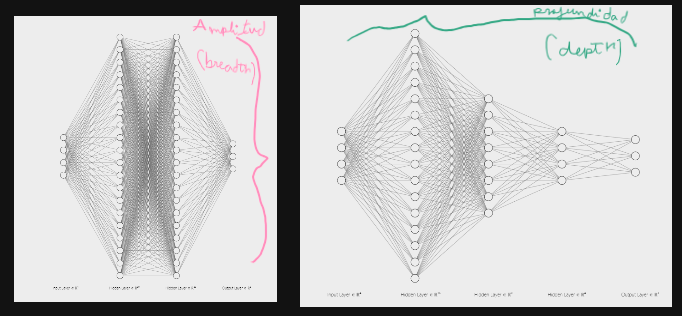

### Manipularemos ambos atributos/parámetros. Para tener una gráfica que muestre en el eje x el número de nodos que tiene cada capa oculta **(amplitud)**, en el eje y la precisión de cada modelo, y trazas dentro de dicha gráfica para cada modelo con distinto número de capas ocultas **(profundidad)**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
plt.style.use("dark_background")

## Cargamos los datos

In [155]:
import seaborn as sns

df_iris = sns.load_dataset("iris")
# sns.pairplot(df_iris, hue="species");

from sklearn.preprocessing import LabelEncoder
#transformamos las etiquetas (y) de los datos a ser números desde 0 a n_clases-1
label_enc = LabelEncoder()

labels = label_enc.fit_transform(df_iris.species)

X = torch.tensor(df_iris.iloc[:,0:4].values).float() #matriz de características
y = torch.tensor(labels).long() #vector de las etiquetas transformadas a números (tipo de dato long() -> entero) #podiamos tambien haber hecho df.iris[df.iris.species=="setosa"] == 1 y así

## Definiendo la función que cree el modelo en cada experimento

In [131]:
class Model(nn.Module):
    
    def __init__(self, n_units, n_layers): #tomamos en el constructor de la clase los dos parámetros
        super().__init__()
        
        #diccionario para almacenar las capas
        self.layers = nn.ModuleDict() 
        self.n_layers = n_layers 
        
        ### capa de entrada
        self.layers["input"] = nn.Linear(4, n_units) #4 características entrada que las tomará 1 capa de salida (fija) para todo modelo
        
        ### capa(s) ocultas -> tantas como indique n_layers con tantos nodos como indique n_units
        for i in range(n_layers):
            self.layers[f"hidden{i}"] = nn.Linear(n_units, n_units) #almacenaremos dicha capa asignándole un nombre hidden seguido de la posición
        
        ### capa de salida
        self.layers["output"] = nn.Linear(n_units, 3)
        
        
    def forward(self, x):
        
        x = self.layers["input"](x) #nos referimos a la capa de entrada y realizamos la suma lineal ponderada
        x = F.relu(x)
        
        for i in range(self.n_layers):
            x = F.relu(self.layers[f"hidden{i}"](x)) #aplicamos relu(suma lineal ponderada) para cada nodo de la capa oculta actual
        
        #capa de salida
        x = self.layers["output"](x)
        
        return x

## Testeando lo que hemos creado

In [22]:
#probaremos con un modelo de (4)+1 = 5 capas ocultas con 8 nodos en cada una
n_layers = 4
n_units = 8

model = Model(n_units=n_units, n_layers=n_layers)

In [23]:
model

Model(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=8, bias=True)
    (hidden0): Linear(in_features=8, out_features=8, bias=True)
    (hidden1): Linear(in_features=8, out_features=8, bias=True)
    (hidden2): Linear(in_features=8, out_features=8, bias=True)
    (hidden3): Linear(in_features=8, out_features=8, bias=True)
    (output): Linear(in_features=8, out_features=3, bias=True)
  )
)

### Verificamos que la arquitectura es consistente internamente

In [33]:
#testear el modelo sobre algunos datos (verificar las dimensiones de las entradas, salidas...etc) -> cuando pueden aparecer errores

random_data = torch.rand(10,4) #para probar, usamos 10 observaciones de números aleatorios con 4 dimensiones esperadas, siendo tensor de 10x4
#imagina, en este contexto de las flores iris, serían medidas de 10 flores aleatorias, con 4 características cada una (pétalos, sépalo...etc)

random_pred = model(random_data)

print(random_pred.shape), print("")
print(random_pred)

torch.Size([10, 3])

tensor([[ 0.0404, -0.1994, -0.2378],
        [ 0.0392, -0.1983, -0.2371],
        [ 0.0386, -0.1977, -0.2370],
        [ 0.0381, -0.1972, -0.2366],
        [ 0.0395, -0.1985, -0.2374],
        [ 0.0387, -0.1980, -0.2366],
        [ 0.0413, -0.1996, -0.2393],
        [ 0.0396, -0.1985, -0.2377],
        [ 0.0391, -0.1984, -0.2368],
        [ 0.0401, -0.1988, -0.2381]], grad_fn=<AddmmBackward0>)


## Definiendo una función que entrene el modelo

In [38]:
def train(model):
        
    loss_func = nn.CrossEntropyLoss() #ver docs (usa LogSoftmax debido a la propiedad de los logaritmos de hacer los números pequeños "más espaciados")
    #por lo que añade el logaritmo a la función softmax

    learning_rate = 0.01

    optim = torch.optim.SGD(model.parameters(), lr=learning_rate)

    n_epochs = 1000

    losses = torch.zeros(n_epochs) #para almacenar las pérdidas para cada epoch
    accuracies = [] #almacenamos la métrica de precisión en cada epoch

    for epoch in range(n_epochs): #tqdm

        #forward pass
        y_hat = model(X)

        #compute error
        loss = loss_func(y_hat, y)
        losses[epoch] = loss

        #backward pass
        optim.zero_grad() #clear previous gradients cache
        loss.backward() #compute gradients based on the error
        optim.step() #update parameters
        
        matches = torch.argmax(y_hat, axis=1) == y #obtenemos para cada output del modelo, el índice de la salida más alta -> categoría
        matches_num = matches.float()

        #la media de predicciones acertadas multiplicada por 100
        acc_pct = 100*torch.mean(matches_num)    
        accuracies.append(acc_pct)
        

    # #"final forward pass" - post entrenamiento
    preds = model(X)
    preds_labels = torch.argmax(preds, axis=1)
    total_acc = 100*torch.mean((preds_labels == y).float())
    
    #número total de parámetros de aprendizaje en el modelo
    n_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
    
    return total_acc, n_params

### Otro pequeño test sobre la función de entrenamiento

In [47]:
n_epochs = 2500
acc, n_params = train(model)
#comprobamos que retorne lo esperado, dimensiones correctas -> tupla con (precisión final, número parámetros)
print(acc)
print("")
print(n_params)

tensor(98.)

355


## Hora del Experimento!

- ### Variaremos el número de capas ocultas de 1-6 y el número de nodos por capa oculta de 4 a 101 en pasos 3 en 3

In [49]:
n_layers = range(1,6)
n_units = np.arange(4, 101, 3)

#inincializamos los resultados
accuracies = np.zeros((len(n_units), len(n_layers)))
total_params = np.zeros((len(n_units), len(n_layers)))

n_epochs = 500

#para cada valor de nodos, iremos probando con todas las combinaciones de número de capas ocultas
for unit_idx in range(len(n_units)):
    
    for layer_idx in range((len(n_layers))):
        
        model = Model(n_units=n_units[unit_idx],
                     n_layers=n_layers[layer_idx])
        
        #almacenamos resultados del entrenamiento, y los parámetros entrenables
        acc, n_params = train(model)
        accuracies[unit_idx, layer_idx] = acc
        total_params[unit_idx, layer_idx] = n_params

## Graficamos la precisión en función de la profundidad del modelo (con leyenda indicando nº nodos)

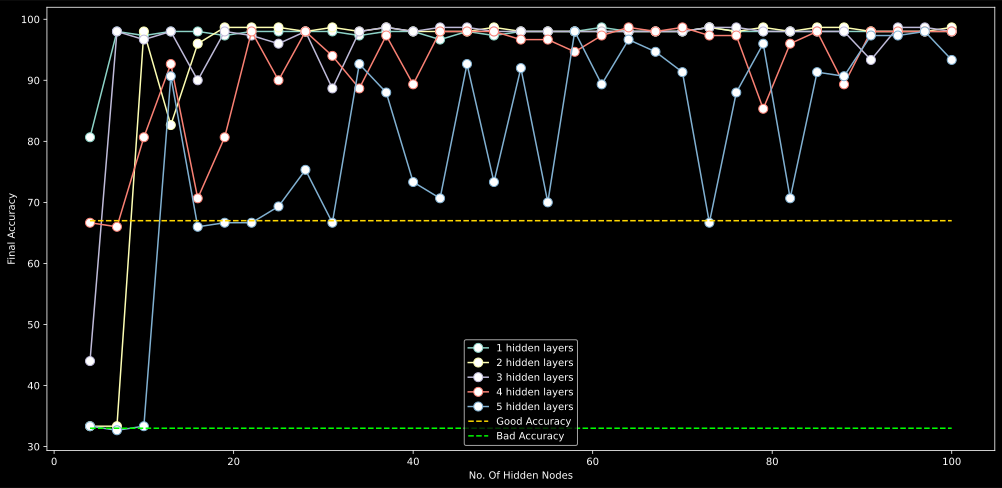

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17,8))

ax.plot(n_units, accuracies, "o-", markerfacecolor="w", markersize=9);
ax.plot(n_units[[0,-1]], [67,67], "--", color="gold", label="Good Accuracy")
ax.plot(n_units[[0,-1]], [33,33], "--", color="lime", label="Bad Accuracy")
ax.set_xlabel("No. Of Hidden Nodes")
ax.set_ylabel("Final Accuracy")
ax.legend([f"{n} hidden layers" for n in list(n_layers)] + ["Good Accuracy", "Bad Accuracy"]);

plt.show();

- ### Para este caso, vemos que modelos más sencillos (menos profundidad de capas ocultas) (color verde por ejemplo) resultan obtener una precisión más clara y rápida con apenas amplitud (menor cantidad de nodos por capa oculta) de alrededor 10 nodos por capa oculta

- ### Por lo tanto, modelos complejos, profundos y amplios no resultan ser siempre la mejor opción

________

### Graficando ahora la precisión en base al número total de parámetros del modelo

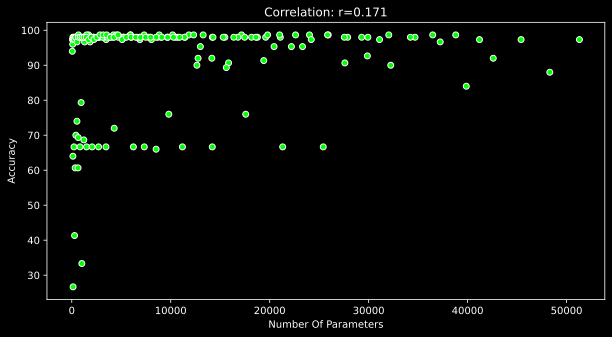

In [159]:
params_flatt = total_params.flatten()
accs_flatt = accuracies.flatten()

corr = np.corrcoef(params_flatt,accs_flatt)[0,1]

plt.figure(figsize=(10,5))
plt.plot(params_flatt,accs_flatt, "ow", markerfacecolor="lime")
plt.xlabel("Number Of Parameters")
plt.ylabel("Accuracy")
plt.title("Correlation: r=" + str(np.round(corr,3)))
plt.show();

### - Podemos ver cómo tiene 0 correlación la precisión en base al número de parámetros entrenables del modelo

__________

## Additional Explorations C:\Users\pablo\Mi unidad\Neural Networks\resources\courses\Udemy\A deep understanding of deep learning (with Python intro) - Mike X Cohen\code\ANN\DUDL_ANN_breadthVsDepth.ipynb

1) Try it again with 1000 training epochs. Do the deeper models eventually learn?

In [132]:
n_layers = range(1,6)
n_units = np.arange(4, 101, 3)

#inincializamos los resultados
accuracies = np.zeros((len(n_units), len(n_layers)))
total_params = np.zeros((len(n_units), len(n_layers)))

n_epochs = 1000

#para cada valor de nodos, iremos probando con todas las combinaciones de número de capas ocultas
for unit_idx in range(len(n_units)):
    
    for layer_idx in range((len(n_layers))):
        
        model = Model(n_units=n_units[unit_idx],
                     n_layers=n_layers[layer_idx])
        
        #almacenamos resultados del entrenamiento, y los parámetros entrenables
        acc, n_params = train(model)
        accuracies[unit_idx, layer_idx] = acc
        total_params[unit_idx, layer_idx] = n_params

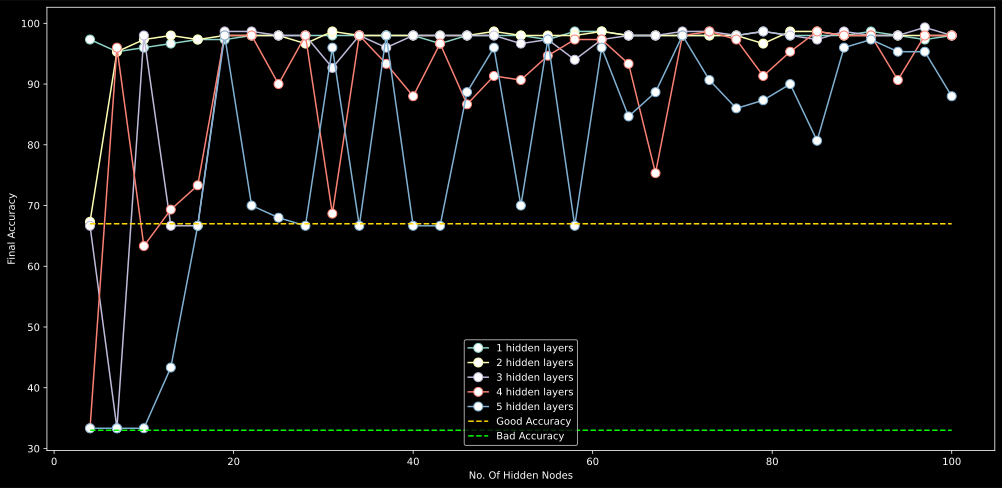

In [133]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17,8))

ax.plot(n_units, accuracies, "o-", markerfacecolor="w", markersize=9);
ax.plot(n_units[[0,-1]], [67,67], "--", color="gold", label="Good Accuracy")
ax.plot(n_units[[0,-1]], [33,33], "--", color="lime", label="Bad Accuracy")
ax.set_xlabel("No. Of Hidden Nodes")
ax.set_ylabel("Final Accuracy")
ax.legend([f"{n} hidden layers" for n in list(n_layers)] + ["Good Accuracy", "Bad Accuracy"]);

plt.show();

Vemos que con `1,000` epochs, los modelos más profundos no consiguen "aprender" puediendo sobreajustarse.

2) The categories are coded a "0", "1", and "2". Is there something special about those numbers?
   Recode the labels to be, e.g., 5, 10, and 17. Or perhaps -2, 0, and 2. Is the model still able to learn?


No afecta al modelo, ya que hacemos el mismo procedimiento de obtención del índice con valor más alto usando argmax...etc. Pero la función de pérdida espera que estén codificados en orden

Por lo tanto, al ver que las etiquetas no comienzan por 1 y no van por orden, la mapeación de PyTorch se ve afectada, saltando el error `Index Error: Target 3 is out of bounds`

_________